<a href="https://colab.research.google.com/github/r-wisniewski/xG-LinearModel/blob/main/AHL_xG_LinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acknowledgements

This project is heavily based on the linear model found here: https://www.tensorflow.org/tutorials/estimator/linear

In [1]:
%tensorflow_version 2.x

!pip install -q sklearn

#from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print(tf.version)
import matplotlib.pyplot as plt # Dataset visualization.
import numpy as np              # Low-level numerical Python library.
import pandas as pd             # Higher-level numerical Python library.
from IPython.display import clear_output

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>




---
# Import scraped data

This step imports scraped event data (using ahl_scraper.py) from a csv file. Once imported, the labels and data are separated.


In [2]:
#import training and test data from csv's
# training data is from game id's 1017122 to 1020000
xg_df_train = pd.read_csv('https://github.com/r-wisniewski/xG-LinearModel/raw/main/training.csv')
# testing data is from game id's 1020001 to 1020558. 1020558 is the latest game we have data for
xg_df_testing = pd.read_csv('https://github.com/r-wisniewski/xG-LinearModel/raw/main/testing.csv')

# separate the labels and data
y_train = xg_df_train.pop('Goal')
y_testing = xg_df_testing.pop('Goal')

### Check the imported data

Let's have a quick look at what data has been imported

In [3]:
#check the first few rows of the training panda dataframe
xg_df_train.head()


,XLocation,YLocation,Strength
0,128,29,0
1,207,122,0
2,128,225,1
3,110,94,1
4,53,174,1


In [4]:
# Lets see how the labels are stored
y_train.head()

0    False
1    False
2    False
3    False
4    False
Name: Goal, dtype: bool



---

# Let's train!
Now that both the training and test data have been collected, let's train the model!

Since all the data is numerical, there is no need to convert any categorical data to numerical. Newer AHL game summaries are beginning to track types of shots, when enough of those game summaries are available we could implement shot type as an additional feature.

### Create the input function

In [5]:
# data_df = all data in table form, label_df = all associated labels in table form
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    # Convert the pandas dataframe into a tf.data.Dataset object. We want to convert our pandas "table" to this new object type before processing.
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its associated label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  ####### return a function object for use ######

train_input_fn = make_input_fn(xg_df_train, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(xg_df_testing, y_testing, num_epochs=1, shuffle=False) # we aren't training it here anymore so 1 epoch and no shuffling

In [6]:
numeric_columns = ['XLocation', 'YLocation', 'Strength']
feature_columns = []
for feature_name in numeric_columns:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn)  # uses the passed function "train_input_fn" to grab data and train the model
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by running the model on testing data

# lets see how accurate the model is
print(result['accuracy'])
print(result) # see what evaluate() returns

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp0c9zkq4x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initiali

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp0c9zkq4x/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 678.654
INFO:tensorflow:loss = 0.39318666, step = 100 (0.149 sec)
INFO:tensorflow:global_step/sec: 1043.71
INFO:tensorflow:loss = 0.46678898, step = 200 (0.095 sec)
INFO:tensorflow:global_step/sec: 918.054
INFO:tensorflow:loss = 0.44156665, step = 300 (0.109 sec)
INFO:tensorflow:global_step/sec: 1008.94
INFO:tensorflow:loss = 0.38285398, step = 400 (0.101 sec)
INFO:tensorflow:

We've achieved a 90.15% accuracy in estimating the events in the testing set, a set of data that is out of sample. This is data the linear model has not been trained on or has seen yet.

# Let's make some predictions

We can predict the expected goals of an event (x,y,strength) using the `.predict()` method. Using the `.predict()` method, we'll be able to predict the expected goals and generate heat maps for each strength.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0c9zkq4x/model.ckpt-50770


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


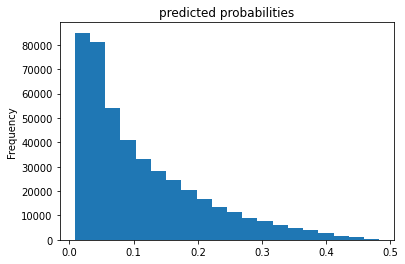

In [7]:
#import prediction data from csv
xg_df_predict = pd.read_csv('https://github.com/r-wisniewski/xG-LinearModel/raw/main/prediction.csv')
y_pred = np.zeros(len(xg_df_predict.index)) #generate a zeros array for the input function. 

# generate the prediction input function
pred_input_fn = make_input_fn(xg_df_predict, y_pred, num_epochs=1, shuffle=False)

# cast the predict return to a list. If not casted use next(pred_xxxx)
pred_dicts = list(linear_est.predict(pred_input_fn)) # this returns a predictions array (whether or not the event is a goal) for EACH input test data 
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts]) # take each prediction array and strip off the 2nd element ([1]) which is the chance of this event being a goal. Add to a pd.series.

probs.plot(kind='hist', bins=20, title='predicted probabilities') # plot all probabilities

# Check the xG

Let's check some x,y,strength combinations and see the expected goals.

In [15]:
print(xg_df_predict.loc[122122])
print(pred_dicts[122122]['probabilities'])

XLocation    0
YLocation    0
Strength    -2
Name: 0, dtype: int64
[0.90043026 0.09956978]


This arbitrarily chosen row (122122) is location 108,217 on the ice at a strength of -1 which means its either 4v5 or 3v4 (for the shooter). The returned prediction array `[0.94418013 0.05581985]` means there is a 94.4% chance a show from this x,y,strength combination will not result in a goal and a 5.5% chance it will result in a goal.

# Generate heat maps

Now we are able to generate heat maps for each strength.

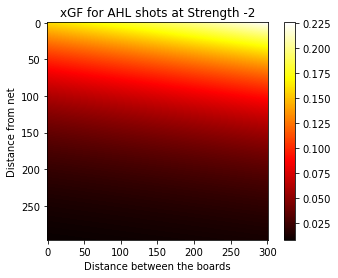

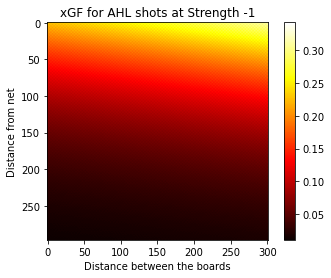

KeyError: ignored

In [19]:
#!pip install -q tkinter
#import tkinter
#import matplotlib
#matplotlib.use('TkAgg')

num_rows = int((xg_df_predict.size)/3) - 1

# 89,398 rows per strength
for i in range(-2,3):
    #Create numpy array that will be populated by our records
    #shape = (rows,columns) in our case rows are the y's and columns are the x's
    rows = 297
    cols = 301
    A = np.ndarray(shape=(rows,cols), dtype=float)

    for n in range(89398):
        row_num = 89397*(i+2) + n*(i+3)
        x = xg_df_predict.loc[row_num, 'XLocation']
        y = xg_df_predict.loc[row_num, 'YLocation']
        #A[x][y] = xG
        A[x,y] = pred_dicts[row_num]['probabilities'][1]
        #print("Array element (%i,%i) is %6.5f" % (x,y,pred_dicts[row_num]['probabilities'][1]))
        
    plt.xlabel('Distance between the boards')
    plt.ylabel('Distance from net')
    title = 'xGF for AHL shots at Strength %s' % i
    plt.title(title)
    im = plt.imshow(A, cmap='hot')
    plt.colorbar(im)
    plt.show()